Applying the Machine Learning Model on the processed dataset.

In [4]:
# Importing the libraries
import pandas as pd
import numpy as np
import torch
import random

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import ElectraTokenizer
from transformers import BertTokenizer
from transformers import ElectraForSequenceClassification, AdamW, BertConfig
from keras.utils import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


import time
import datetime
import plotly.express as px


In [5]:
# Importing the fake news and valid news dataset
fake_news = pd.read_csv('Data_Approach1\\fake_news.csv')
true_news = pd.read_csv('Data_Approach1\\true_news.csv')


In [6]:
# Deleting the unanmed column
true_news = true_news.drop(['Unnamed: 0'], axis=1)
fake_news = fake_news.drop(['Unnamed: 0'], axis=1)


In [7]:
# Making both length equal in order to obtain an unbiased dataset.

if len(fake_news) > len(true_news):
    fake_news = fake_news.head(len(true_news))
elif len(true_news) > len(fake_news):
    true_news = true_news.head(len(fake_news))
print("Length of fake news: ", len(fake_news))
print("Length of true news: ", len(true_news))


Length of fake news:  760
Length of true news:  760


In [8]:
# Providing the labels as true = 1 and Fake = 0
true_news['label'] = 1
fake_news['label'] = 0
news = pd.concat([fake_news, true_news])


In [9]:
news

,short_description,label
0,बूम पाय इमरान खान भारत सरकार आलोच रह वर्तमान श...,0
1,सिख समुदाय के लोग हिंद साइन बोर्ड कालिख पोत दि...,0
2,सोशल मीडिय प्लेटफ़ॉर्म फ़ेसबुक ट्विटर दाव के बड़ ...,0
3,दाव भाजप के मा सरकार जन के गलत रह,0
4,मीडिय आउटलेट्स वायर एजेंस गलत तरीक दाव किय पाक...,0
...,...,...
755,चालक कार रोक के बजाय चल जार रख ट्रैफ़िक पुलिसक...,1
756,मिसाइल 400 किलोमीटर ज़्याद मार सक,1
757,आकर्षण केंद्र वो शक्तिशाल पहलवान जिनक संबंध प्...,1
758,बिहार के जातिगत समीकरण बात लंब बीजेप हिंद पहचा...,1


In [10]:
# Shuffling the fake news and valid news using scikit learn shuffle
news = shuffle(news)


In [11]:
print("Final Dataset: ")
news

Final Dataset: 


,short_description,label
158,किसान सरकार के छठ दौर बातचीत पहल जान पूर्व कृष...,1
566,टिकट बंटवार के लिहाज देख सत् पक्ष के चार घटक द...,1
694,उत्तर प्रदेश के ललितपुर मध्य प्रदेश के भोपाल ट...,1
512,बूम पाय यूनिसेफ़ ऐस एडवाइज़र जार नह मैसेज ज्यादा...,0
14,दाव पाकिस्तान उपद्रव द्वार मंदिर तोड़ मुसलमान प...,0
...,...,...
270,बूम पाय तस्वीर 2018 मामल किड पथर निकलव आय मरीज़...,0
639,भारतीय खुफ़िय एजेंस के प्रमुख प्रमुख के नेपाल ...,1
450,बूम रवीश कुमार बात वायरल बयान सिर ख़ारिज किय,0
542,पाकिस्तान अफ़ग़ानिस्तान के अनबन जित पुरा उत पु...,1


In [12]:
# Converting the final dataset to a csv file.
news.to_csv('Data_Approach1\\Final_Dataset.csv')


Training the Model

In [13]:
# Get the GPU device name.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.empty_cache()


cuda


In [14]:
# Splitting the train test dataset using the scikit learn
train, test, labels, y_test = train_test_split(
    news, news['label'], test_size=0.2, stratify=news['label'], random_state=140, shuffle=True)

# Storing the short description to sentences and label values in labels.
sentences = train.short_description.values
labels = labels.values


In [15]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer')
tokenizer = ElectraTokenizer.from_pretrained(
    'monsoon-nlp/hindi-tpu-electra', do_lower_case=True)


Loading BERT tokenizer


In [16]:
# Bert Tokenizer: We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models, BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.


In [17]:
# Tokenizing all of the sentences(separating the words) and map the tokens to thier word IDs.

input_ids = []
for sent in sentences:
    encoded_sent = tokenizer.encode(
        sent,
        add_special_tokens=True,  
        # max_length = 64,          # Truncate all sentences.
        # return_tensors = 'pt',     # Return pytorch tensors.
    )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0 and 1, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Original: ', sentences[1])
print('Token IDs:', input_ids[1])


Original:  बूम सुल्तानपुर पुलिस के आल अधिकार बात बत घट साम्प्रदायिक कोण नह 
Token IDs: [3, 22699, 20742, 3834, 1885, 3215, 2968, 2674, 6233, 4717, 28512, 7010, 14578, 4]
Original:  यूज़र्स तस्वीर हालिय किसान आंदोलन जोड़ शेयर रह 
Token IDs: [3, 0, 7631, 2429, 1919, 6975, 4265, 0, 5316, 2058, 4]


<AxesSubplot:>

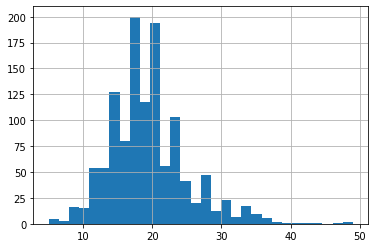

In [18]:
# Plotting the input ids
seq_len = [len(sen) for sen in input_ids]
pd.Series(seq_len).hist(bins=30)


In [19]:
# Checking the max length in input id
print('Max sentence length: ', max([len(sen) for sen in input_ids]))


Max sentence length:  49


In [20]:
# Set the maximum sequence length as 128 , as it should be slightly above 105

MAX_LEN = 96
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(
    tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                          value=0, truncating="post", padding="post")
print('\Done.')



Padding/truncating all sentences to 96 values...

Padding token: "[PAD]", ID: 2
\Done.


In [21]:
# Create attention masks

attention_masks = []
for sent in input_ids:

    # Create the attention mask. If a token ID is 0, then it's padding, set the mask to 0. If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]

    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)


In [22]:
# Use train_test_split to split our data into train and validation sets for training, 10% validation

from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                                                    random_state=140, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                                       random_state=140, test_size=0.1)


In [23]:
# Convert all inputs and labels into torch tensors, the required datatype for our model.

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)


In [24]:
# The DataLoader needs to know our batch size for training, so we specify it here.
batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(
    train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(
    validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(
    validation_data, sampler=validation_sampler, batch_size=batch_size)


In [25]:
# Code snippet for deleting the gpu cache
from GPUtil import showUtilization as gpu_usage
from numba import cuda


def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()


free_gpu_cache()


Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  9% |  2% |


In [26]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.

model = ElectraForSequenceClassification.from_pretrained(
    # Use the 12-layer BERT model, with an uncased vocab.
    "monsoon-nlp/hindi-tpu-electra",
    num_labels=2,  # The number of output labels--2 for binary classification.
    output_attentions=False,  # Whether the model returns attentions weights.
    output_hidden_states=False,  # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()


Some weights of the model checkpoint at monsoon-nlp/hindi-tpu-electra were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monsoon-nlp/hindi-tpu-electra and are newly initialized: ['classifier.dense.bia

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(39628, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [27]:
# Get all of the model's parameters as a list of tuples.
# Summary of the Model

params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(
    len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 201 different named parameters.

==== Embedding Layer ====

electra.embeddings.word_embeddings.weight               (39628, 768)
electra.embeddings.position_embeddings.weight             (512, 768)
electra.embeddings.token_type_embeddings.weight             (2, 768)
electra.embeddings.LayerNorm.weight                           (768,)
electra.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

electra.encoder.layer.0.attention.self.query.weight       (768, 768)
electra.encoder.layer.0.attention.self.query.bias             (768,)
electra.encoder.layer.0.attention.self.key.weight         (768, 768)
electra.encoder.layer.0.attention.self.key.bias               (768,)
electra.encoder.layer.0.attention.self.value.weight       (768, 768)
electra.encoder.layer.0.attention.self.value.bias             (768,)
electra.encoder.layer.0.attention.output.dense.weight     (768, 768)
electra.encoder.layer.0.attention.output.dense.bias           (

In [28]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# Adam is the optimizer for our model

from transformers import get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),
                  lr=2e-5,  # args.learning_rate
                  eps=1e-8  # args.adam_epsilon  - default is 1e-8.
                  )

epochs = 5
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)


c:\Users\bhavy\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [29]:

# Function to calculate the accuracy of our predictions vs labels

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [30]:
# Function to calculate the time elapsed in one iteration
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [31]:
# Actual training tf the model
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
# Store the average loss after each epoch so we can plot them.
loss_values = []
start = time.time()
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_loss = 0
    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(
                step, len(train_dataloader), elapsed))
        # Unpack this training batch from our dataloader.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Always clear any previously calculated gradients before performing a backward pass.

        model.zero_grad()
        # Perform a forward pass .This will return the loss .
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple.
        loss = outputs[0]
        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end. `loss` is a Tensor containing a single value
        total_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0. This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and  speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions. This will return the logits rather than the loss because we have not provided labels.
            # token_type_ids is the same as the "segment ids"
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model.
        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
print("")
print("Training complete!")
end = time.time()



======== Epoch 1 / 5 ========
Training...
  Batch    40  of     69.    Elapsed: 0:00:17.

  Average training loss: 0.69
  Training epcoh took: 0:00:26

Running Validation...
  Accuracy: 0.41
  Validation took: 0:00:01

======== Epoch 2 / 5 ========
Training...
  Batch    40  of     69.    Elapsed: 0:00:13.

  Average training loss: 0.69
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.41
  Validation took: 0:00:01

======== Epoch 3 / 5 ========
Training...
  Batch    40  of     69.    Elapsed: 0:00:13.

  Average training loss: 0.69
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.41
  Validation took: 0:00:01

======== Epoch 4 / 5 ========
Training...
  Batch    40  of     69.    Elapsed: 0:00:13.

  Average training loss: 0.69
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.41
  Validation took: 0:00:01

======== Epoch 5 / 5 ========
Training...
  Batch    40  of     69.    Elapsed: 0:00:13.

  Average training loss: 0.69
  T

In [32]:
# Plotting the graph of loss vs the epoch

f = pd.DataFrame(loss_values)
f.columns = ['Loss']
fig = px.line(f, x=f.index, y=f.Loss)
fig.update_layout(title='Training loss of the Model',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()


In [33]:
sentences = test.short_description.values
labels = y_test.values
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
for sent in sentences:

    encoded_sent = tokenizer.encode(
        sent,                      # Sentence to encode.
        add_special_tokens=True,  
        max_length=256
    )

    input_ids.append(encoded_sent)
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)
# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
# Set the batch size.
batch_size = 32
# Create the DataLoader.
prediction_data = TensorDataset(
    prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(
    prediction_data, sampler=prediction_sampler, batch_size=batch_size)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [34]:
# Evaluating the model and predicting the labels for new sentences

print('Predicting labels for {:,} test sentences...'.format(
    len(prediction_inputs)))
# Put model in evaluation mode
model.eval()

predictions, true_labels = [], []
# Predict
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)
    logits = outputs[0]
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
print('DONE.')


Predicting labels for 304 test sentences...
DONE.


In [35]:
# Calculating the accuracy of the model

count = 0
guesses = []
actual = []
# For each input batch...
for i in range(len(true_labels)):

    # The predictions for this batch are a 2-column ndarray (one column for "0" and one column for "1"). Pick the label with the highest value and turn this in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

    # calculate accuracy
    for j in range(len(pred_labels_i)):
        if(pred_labels_i[j] == true_labels[i][j]):
            count += 1
        guesses.append(pred_labels_i[j])
        actual.append(true_labels[i][j])


accuracy = count/len(y_test)


In [36]:
# Prinitng the Accuracy of the model
print("Accuracy of the obtained model: ", accuracy)
print(accuracy*100, '%')

Accuracy of the obtained model:  0.5
50.0 %
